# Une méthode basée modèle : le NasPLS

## Méthodologie

L'algorithme **NasPLS** peut se diviser en 4 grandes étapes :
1. La recherche des régions non-sensibles : segmentation automatique du spectre pour identifier les intervalles où l'absorbance tend vers 0.
2. Ajustement pondéré : application d'un schéma de moindres carrés pénalisés avec une pondération adaptative.
3. Sélection de la pénalité $\lambda$ : pour chaque valeur candidate lambda on calcule la $RMSE$ entre le spectre et la baseline uniquement dans les régions non-sensibles. On retient la valeur de lambda qui minimise cette $RMSE$.
4. Itération jusqu'à convergence : mise à jour des poids et de la baseline jusqu'à ce que la variation relative des poids soit inférieur à un certain seuil $\varepsilon$.

## Les grandes lignes de l'algorithme :

### Formulation de la fonction de coût et estimation de la ligne de base

Considérons un signal $ x \in \mathbb{R}^M $ représenté sous forme de vecteur de taille $ M $, ainsi qu’un vecteur $ z \in \mathbb{R}^M $ correspondant à la **ligne de base estimée**.

À partir de ces deux vecteurs, on définit :

- **L’erreur de fidélité (ou distorsion)** $ B $, qui mesure l’écart entre le signal initial et la baseline estimée.
- **La rugosité** $ R $, qui mesure la régularité (ou la lissité) de la baseline.

On introduit un **coefficient de pénalité** $ \lambda > 0 $ dans le terme de rugosité pour établir un compromis entre ces deux objectifs.  
On définit alors la **fonction de coût** $ Q $ comme suit :

$ Q = B + \lambda R $

---

#### Formulation matricielle

Sous forme matricielle, on peut écrire la fonction de coût :


$Q = \| x - z \|^2 + \lambda \| D z \|^2$

où :
- $ x $ est le signal mesuré ($ M \times 1 $),
- $ z $ est la baseline estimée ($ M \times 1 $),
- $ D $ est une matrice de différences finies (ou un opérateur de dérivation discrète) qui mesure la rugosité de $ z $.

---

#### Minimisation de $Q$

Pour estimer  $z$ , on cherche à minimiser $Q$.  
On calcule donc la dérivée partielle de $Q$ par rapport à $z$ et on résout :


$\frac{\partial Q}{\partial z} = 0$


Cela conduit à l’équation matricielle suivante :


$(I + \lambda D^{\mathsf{T}} D) z = x$

et donc l’estimation fermée de la baseline s’écrit :


$z = (I + \lambda D^{\mathsf{T}} D)^{-1} x$

où :
- $I$ est la matrice identité de taille $M \times M$,
- $D^{\mathsf{T}}$ est la transposée de $D$.

### Pondération pour l’élimination des pics

Pour éviter que la baseline ne suive les pics du signal, on introduit un **vecteur de poids** $w$ et une **matrice diagonale** $W = \mathrm{diag}(w_1, \dots, w_M)$.

- Si $x_i > z_i$ (pic), on attribue un poids plus faible voire nul à ce point.
- Si $x_i < z_i$ (creux), on lui donne un poids plus élevé pour renforcer le lissage.

La solution de $z$ devient alors :

$z = (W + \lambda D^{\mathsf{T}} D)^{-1} W x$


## Algorithme NasPLS

### Déroulement de l'algorithme

L’algorithme **NasPLS** suit une procédure itérative pour estimer et corriger la ligne de base d’un spectre.  
Il peut être décrit en quatre grandes étapes :

---

### 1. Initialisation

- Les vecteurs d’adaptation $ \alpha $ et la matrice de poids $ W $ sont initialisés à des valeurs unitaires.
- $ D $ est la matrice de différences finies d’ordre 2 (opérateur de dérivation discrète).
- Paramètres typiques :
  - Nombre d’itérations : $ 50 $
  - Pénalité initiale : $ \lambda = 1000 $
  - Seuil de tolérance : $ \varepsilon = 10^{-4} $

- Les **NAS** (*Non-Absorbing Segments*, ou *régions non sensibles*) sont définis automatiquement à partir du spectre.

---

### 2. Boucle itérative principale

**a. Estimation de la baseline**  
À chaque itération, on estime la baseline $ z $ en résolvant :

$$
z = (W + \lambda D^{\mathsf{T}} D)^{-1} W x
$$

où :
- $ W = \mathrm{diag}(w_i) $ est une matrice diagonale qui module localement l’influence de chaque point du spectre.

---

**b. Sélection de $ \lambda $**  
Pour chaque valeur candidate de $ \lambda $, on calcule l’erreur quadratique moyenne (RMSE) **uniquement dans les NAS** :

$$
\mathrm{RMSE}(\lambda) = \sqrt{ \frac{1}{N_{\mathrm{NAS}}} \sum_{i \in \mathrm{NAS}} (x_i - z_i)^2 }
$$

On retient la valeur de $ \lambda $ qui minimise cette erreur.

---

**c. Mise à jour des poids $ w_i $**  
On calcule les résidus :

$$
d_i = x_i - z_i
$$

et on extrait la partie négative :

$$
d_i^- = \min(d_i, 0)
$$

On évalue ensuite la moyenne et l’écart-type de $ d^- $ ($ \mu_{d^-} $, $ \sigma_{d^-} $) pour définir les poids :

$$
w_i =
\begin{cases}
\displaystyle \left( 1 + \exp\left( \frac{d_i - \sigma_{d^-}}{\mu_{d^-}} \right) \right)^{-1}, & d_i \geq 0 \\
1, & d_i < 0
\end{cases}
$$

Enfin, la pénalité peut être adaptée dynamiquement selon :

$$
\lambda_i = \frac{|d_i|}{\max_j |d_j|}
$$

---

### 3. Critère d’arrêt

La convergence est atteinte lorsque la variation relative des poids devient inférieure au seuil $ \varepsilon $ :

$$
\frac{\| w^{(k)} - w^{(k-1)} \|}{\| w^{(k)} \|} \leq \varepsilon
$$

Si ce critère est satisfait, on arrête l’algorithme ; sinon, on retourne à l’étape 2.

---

### 4. Sortie

À la fin du processus, la baseline corrigée $ z $ est renvoyée comme résultat final.


### NasPLS appliqué à l'article

L’algorithme NasPLS que nous implémentons ici suit les principes décrits par Zhang *et al.* (2025) [https://doi.org/10.1016/j.vibspec.2025.103806](https://doi.org/10.1016/j.vibspec.2025.103806).


#### Import des bibliothèques

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags # on manipulera des matrices creuses ce qui est plus rapide pour de gros signaux
from scipy.sparse.linalg import spsolve # pour résoudre des systèmes linéaires (calculs de baseline)
import pandas as pd

In [2]:
np.random.seed(0) # pour que les résultats soient identiques (à cause du bruit ajouté aléatoirement)

#### Création du signal (Équation 20)

In [3]:
def signal_simule(x):
    return (2 * np.exp(-(x - 200) ** 2 / 400) +
            np.exp(-(x - 400) ** 2 / 400) +
            2 * np.exp(-(x - 500) ** 2 / 1600) +
            2 * np.exp(-(x - 800) ** 2 / 900) +
            4 * np.exp(-(x - 1000) ** 2 / 2500) +
            0.5 * np.exp(-(x - 1300) ** 2 / 225) +
            np.exp(-(x - 1500) ** 2 / 400) +
            1.5 * np.exp(-(x - 1800) ** 2 / 400) +
            2 * np.exp(-(x - 2000) ** 2 / 225) +
            3 * np.exp(-(x - 2200) ** 2 / 400))

#### Création des baselines (Équation 21)

In [4]:
def baseline_linear(x):         return -0.01 + 0.003 * x
def baseline_sinusoide(x):      return 3 * np.sin(np.pi * x / 1300)
def baseline_gaussienne(x):     return 2 * np.exp(-((x - 200) / 400) ** 2) + 2 * np.exp(-((x - 1000) / 300) ** 2)
def baseline_exponentielle(x):  return 3 * np.exp(-x / 200)

#### Création de la matrice de second ordre

In [5]:
# But : construire la matrice qui calcule la dérivée seconde discrète du signal (sert à “lisser” la baseline en la rendant aussi plate que possible).
# C’est cette matrice qui force la baseline à ne pas “suivre” le bruit mais à rester lisse (plus λ est grand, plus la baseline est lisse).
# Elle sert à calculer à quel point la baseline est courbée entre guillemets

def mat_diff_snd_ordre(N):
    diagonals = [np.ones(N), -2*np.ones(N), np.ones(N)]
    return diags(diagonals, [0, 1, 2], shape=(N-2, N))

In [6]:
N = 5 # Exempe tiré du site Whittaker Baselines depuis l'introduction
D = mat_diff_snd_ordre(N)
D_dense = D.toarray()  # conversion en matrice pleine parce que D est creuse

print("Voici la matrice D (différence seconde discrète) :")
print(D_dense)

Voici la matrice D (différence seconde discrète) :
[[ 1. -2.  1.  0.  0.]
 [ 0.  1. -2.  1.  0.]
 [ 0.  0.  1. -2.  1.]]


#### Algos de baselines

##### AsLS

In [7]:
def asls(y, lam=1e5, p=0.001, niter=10):
    """p est le param d'asym qui favorise la baseline sous le signal"""
    N = len(y)
    D = mat_diff_snd_ordre(N)
    w = np.ones(N) # on initialise un vecteur de poids avec 1 pour chaque point du signal
    for i in range(niter):
        W = diags(w, 0)
        Z = spsolve(W + lam * D.T @ D, w * y) 
        # On cherche la baseline Z qui passe “le plus près possible” du signal y sur les zones où le poids w est grand et qui reste “lisse” grâce au terme lambda DTD.
        w = p * (y > Z) + (1 - p) * (y < Z) # màj asym des poids
        # Si le point du signal est au-dessus de la baseline (y>Z), on lui donne un poids petit (p), donc il compte très peu dans le prochain calcul : on veut que la baseline ignore ces pics.
        # Si le point du signal est en-dessous de la baseline (y<Z), on lui donne un poids grand (1−p), donc il compte beaucoup : la baseline ne doit pas passer au-dessus de ces points.
        # Du coup la baseline va avoir tendance à rester sous les pics.
    return Z

##### AirPLS

In [8]:
def airpls(y, lam=1e5, niter=10):
    N = len(y)
    D = mat_diff_snd_ordre(N)
    w = np.ones(N)
    for t in range(1, niter+1):
        W = diags(w, 0)
        Z = spsolve(W + lam * D.T @ D, w * y)
        d = y - Z
        w = np.where(d >= 0, 0, np.exp(t * d / np.abs(d[d < 0]).mean()))
    return Z

##### ArPLS

In [9]:
def arpls(y, lam=1e5, niter=10):
    N = len(y)
    D = mat_diff_snd_ordre(N)
    w = np.ones(N)
    for _ in range(niter):
        W = diags(w, 0)
        Z = spsolve(W + lam * D.T @ D, w * y)
        d = y - Z
        md = np.mean(d[d < 0]) if np.any(d < 0) else 0
        sd = np.std(d[d < 0]) if np.any(d < 0) else 1
        logistic = 1 / (1 + np.exp(2 * (d - (2*sd - md)) / sd))
        w = np.where(d >= 0, logistic, 1)
    return Z

##### NasPLS

In [ ]:
def naspls(y, mask, lambdas, niter=15, tol=1e-4, y_baseline=None):
    """y est le signal à corriger, mask est le masque des zones non sensibles, lambda est le paramètre de régularisation, niter le nombre d'itérations,
    tol la tolérance pour la convergence et y_baseline est optionnel c'est la baseline réelle utilisée en simulation pour évaluer la performance."""

    N = len(y)
    D = mat_diff_snd_ordre(N)

    best_rmse = np.inf
    best_z = None
    best_lambda = None

    for lam in lambdas:
        w = np.ones(N) # poids pour chaque point du signal
        alpha = np.ones(N) # poids d’adaptation pour la régularisation (spécificité NasPLS)
        z = np.zeros(N) # baseline initiale (mise à zéro pour la première itération)
        for i in range(niter):
            W = diags(w, 0)
            A = W + lam * diags(alpha, 0) @ (D.T @ D)
            z_new = spsolve(A, w * y)
            alpha = np.abs(y - z_new) / (np.max(np.abs(y - z_new)) + 1e-12) # Mise à jour de alpha. Qd la différence en val abs de y-z_new est grande, la pénalité de régularisation est ajustée pour que la baseline ne suive pas de trop près les pics.
            # J'ai ajouté 1e-12 pour éviter d'avoir une division par 0 dans le cas ou y = z_new
            d = y - z_new
            sd = np.std(d[d < 0]) if np.any(d < 0) else 1
            w_new = np.where(d >= 0, 1 / (1 + np.exp((d - sd) / (sd + 1e-12))), 1)
            if np.linalg.norm(w_new - w) / (np.linalg.norm(w) + 1e-12) < tol:
                z = z_new
                break
            w = w_new
            z = z_new
        # RMSE sur zones NS
        if y_baseline is not None:
            rmse = np.sqrt(np.mean((z[mask] - y_baseline[mask])**2))
        else:
            rmse = np.sqrt(np.mean((z[mask] - y[mask])**2))
        if rmse < best_rmse:
            best_rmse = rmse
            best_z = z
            best_lambda = lam
    return best_z, best_lambda, best_rmse

#### Pipeline

In [64]:
def process_baseline(baseline_func, snr_db, lambdas, seuil=0.01):
    """Génération du signal (baseline + pics + bruit avec SNR spécifié).
        Identification des Nas (là où la composante "pics" est inférieure au seuil. 
        Ce sont les zones plates qui vont servir de référence à l'algo.
        Application de tous les algos de baselines.
        Calcul du RMSE pour comparaison des performances de chaque algo.)"""
    
    # Génération du vecteur de données spectrales x
    N = 2500
    x = np.arange(N)

    # Génération du y_baseline
    y_baseline = baseline_func(x)

    # Génération du y_pure
    y_pure = signal_simule(x)

    # Génération du y_noise
    signal_power = np.mean((y_baseline + y_pure)**2)
    noise_power = signal_power / (10**(snr_db/10))
    y_noise = np.random.normal(0, np.sqrt(noise_power), N)

    # Génération du y_total tel que y = y_p + y_b + y_n
    y_total = y_baseline + y_pure + y_noise

    # Recherche des Nas
    non_sensitive_mask = y_pure < seuil

    # Application de l'algo NasPLS
    z_naspls, best_lambda_naspls, best_rmse_naspls = naspls(y_total, non_sensitive_mask, lambdas, y_baseline=y_baseline)

    # Application des algos PLS classiques (lambda fixé médian)
    lam_cls = 1e5 if snr_db < 30 else 1e6
    z_asls = asls(y_total, lam=lam_cls)
    z_airpls = airpls(y_total, lam=lam_cls)
    z_arpls = arpls(y_total, lam=lam_cls)

    # Calcul du RMSE sur toute la baseline

    def rmse(reel, estimee): return np.sqrt(np.mean((reel-estimee)**2))

    rmses = {
        "AsLS": rmse(y_baseline, z_asls),
        "AirPLS": rmse(y_baseline, z_airpls),
        "ArPLS": rmse(y_baseline, z_arpls),
        "NasPLS": rmse(y_baseline, z_naspls)
    }

    return {
        "x": x,
        "y_total": y_total,
        "y_baseline": y_baseline,
        "z_asls": z_asls,
        "z_airpls": z_airpls,
        "z_arpls": z_arpls,
        "z_naspls": z_naspls,
        "mask_ns": non_sensitive_mask,
        "lambda_naspls": best_lambda_naspls,
        "rmse_all": rmses,
    }

#### Affichage des zones Nas détectées par l'algo

In [13]:
n=2500
x=np.arange(2500)
y_p = signal_simule(x)

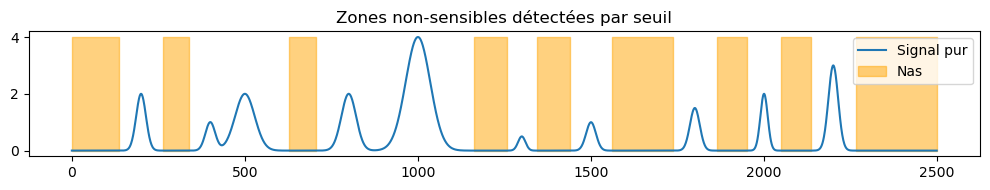

In [14]:
seuil=0.0001
y_pure = signal_simule(x)
non_sensitive_mask = y_pure < seuil

plt.figure(figsize=(10,2))
plt.plot(x, y_pure, label="Signal pur")
plt.fill_between(x, np.max(y_pure), where=non_sensitive_mask, color='orange', alpha=0.5, label="Nas")
plt.legend()
plt.title("Zones non-sensibles détectées par seuil")
plt.tight_layout()
plt.show()

In [15]:
# Définition des variables
N = 2500
x = np.arange(N)
snr_db = 50
seuil= 0.0001
non_sensitive_mask = y_pure < seuil

# Baseline choisie
y_baseline = baseline_linear(x)

# Signal pur
y_pure = signal_simule(x)

# Signal pur + baseline
y_tot = y_baseline + y_pure

# Bruit 1
signal_power = np.mean((y_baseline + y_pure)**2)
noise_power = signal_power / (10**(snr_db/10))
y_noise = np.sqrt(noise_power) * np.random.randn(N)


# Signal total
y_total = y_baseline + y_pure + y_noise



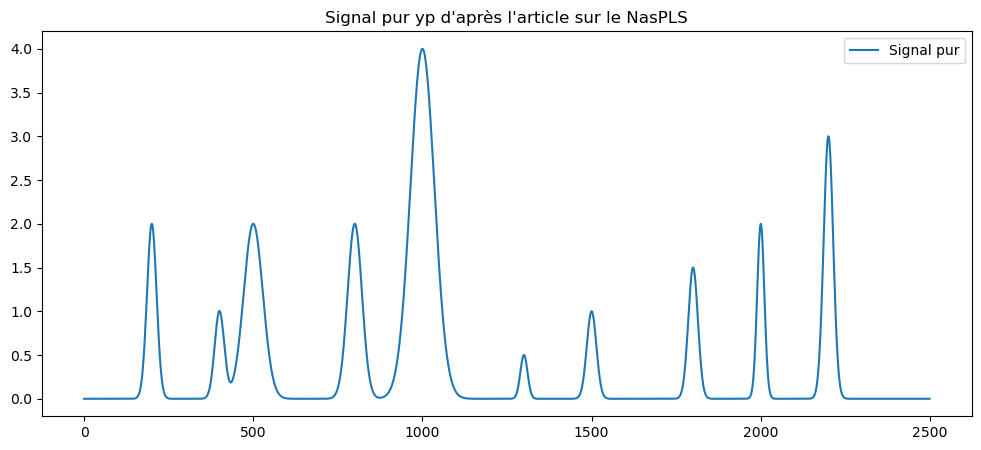

In [17]:
plt.figure(figsize=(12,5))
plt.plot(x, y_pure, label='Signal pur')
plt.legend()
plt.title("Signal pur yp d'après l'article sur le NasPLS")
plt.show()

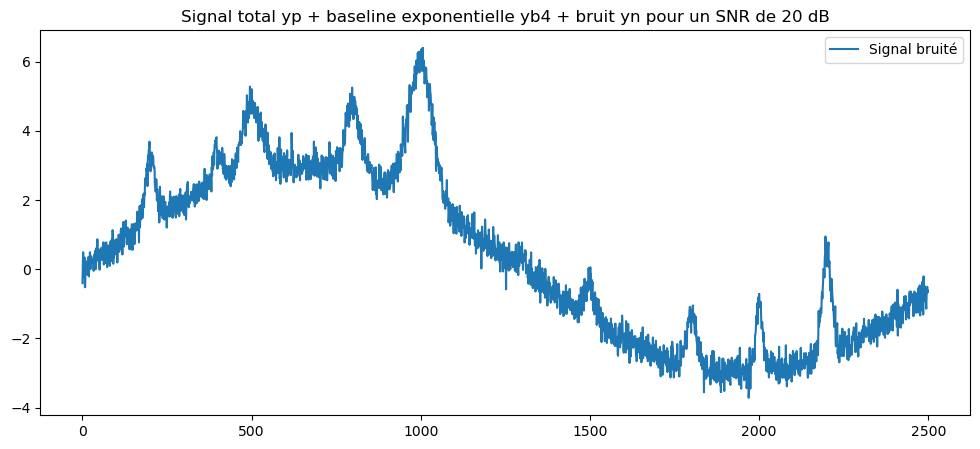

In [18]:
# Baseline choisie
y_baseline = baseline_sinusoide(x)

# Signal pur
y_pure = signal_simule(x)

snr_db = 20
signal_power = np.mean((y_baseline + y_pure)**2)
noise_power = signal_power / (10**(snr_db/10))
y_noise = np.sqrt(noise_power) * np.random.randn(N)

# Signal pur + baseline
y_tot = y_baseline + y_pure

# Signal total
y_total = y_baseline + y_pure + y_noise

plt.figure(figsize=(12,5))
plt.plot(x, y_total, label='Signal bruité')
plt.legend()
plt.title("Signal total yp + baseline exponentielle yb4 + bruit yn pour un SNR de 20 dB")
plt.show()

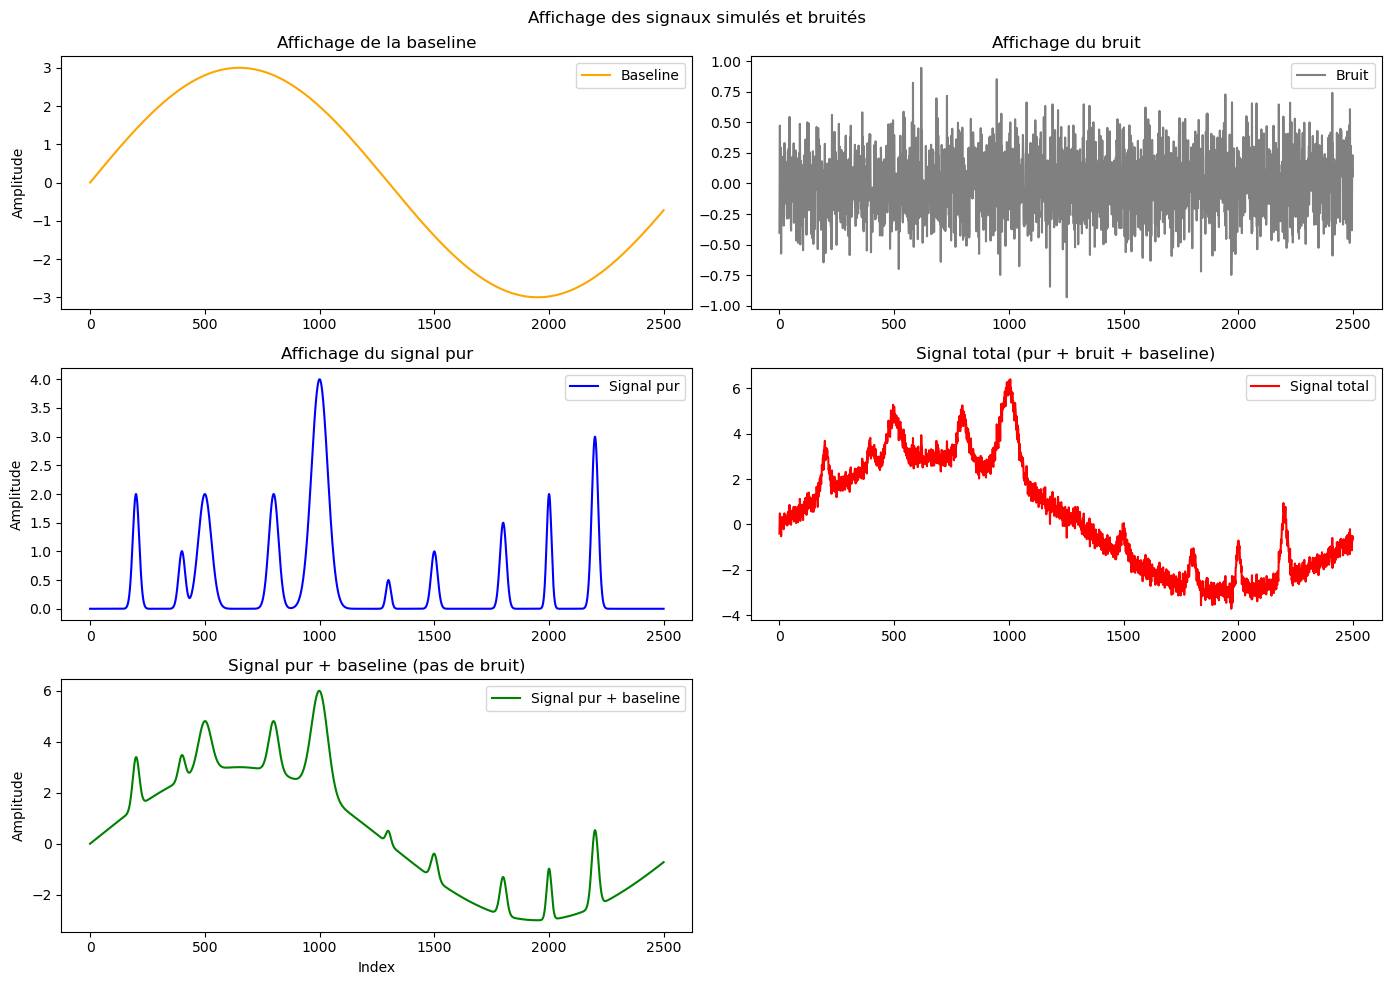

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle("Affichage des signaux simulés et bruités")

axs[0, 0].plot(x, y_baseline, label="Baseline", color="orange")
axs[0, 0].set_title("Affichage de la baseline")
axs[0, 0].set_ylabel("Amplitude")
axs[0, 0].legend()

axs[0, 1].plot(x, y_noise, label="Bruit", color="gray")
axs[0, 1].set_title("Affichage du bruit")
axs[0, 1].legend()

axs[1, 0].plot(x, y_pure, label="Signal pur", color="blue")
axs[1, 0].set_title("Affichage du signal pur")
#axs[1, 0].fill_between(x, np.max(y_pure), where=non_sensitive_mask, color='orange', alpha=0.5, label="Nas")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].legend()

axs[1, 1].plot(x, y_total, label="Signal total", color="red")
axs[1, 1].set_title("Signal total (pur + bruit + baseline)")
#axs[1, 1].fill_between(x, np.max(y_total), where=non_sensitive_mask, color='orange', alpha=0.5, label="Nas")
axs[1, 1].legend()

axs[2, 0].plot(x, y_tot, label="Signal pur + baseline", color="green")
axs[2, 0].set_title("Signal pur + baseline (pas de bruit)")
#axs[2, 0].fill_between(x, np.max(y_tot), where=non_sensitive_mask, color='orange', alpha=0.5, label="Nas")
axs[2, 0].set_xlabel("Index")
axs[2, 0].set_ylabel("Amplitude")
axs[2, 0].legend()

axs[2, 1].axis('off')

fig.tight_layout()


#### Affichage des courbes

##### Avec tous les algorithmes

C:\Users\afaqm\AppData\Local\Temp\ipykernel_17028\3898076214.py:24: RuntimeWarning: overflow encountered in exp
  w_new = np.where(d >= 0, 1 / (1 + np.exp((d - sd) / (sd + 1e-12))), 1)
C:\Users\afaqm\AppData\Local\Temp\ipykernel_17028\4237743565.py:9: RuntimeWarning: overflow encountered in exp
  w = np.where(d >= 0, 0, np.exp(t * d / np.abs(d[d < 0]).mean()))
C:\Users\afaqm\AppData\Local\Temp\ipykernel_17028\515194146.py:11: RuntimeWarning: overflow encountered in exp
  logistic = 1 / (1 + np.exp(2 * (d - (2*sd - md)) / sd))


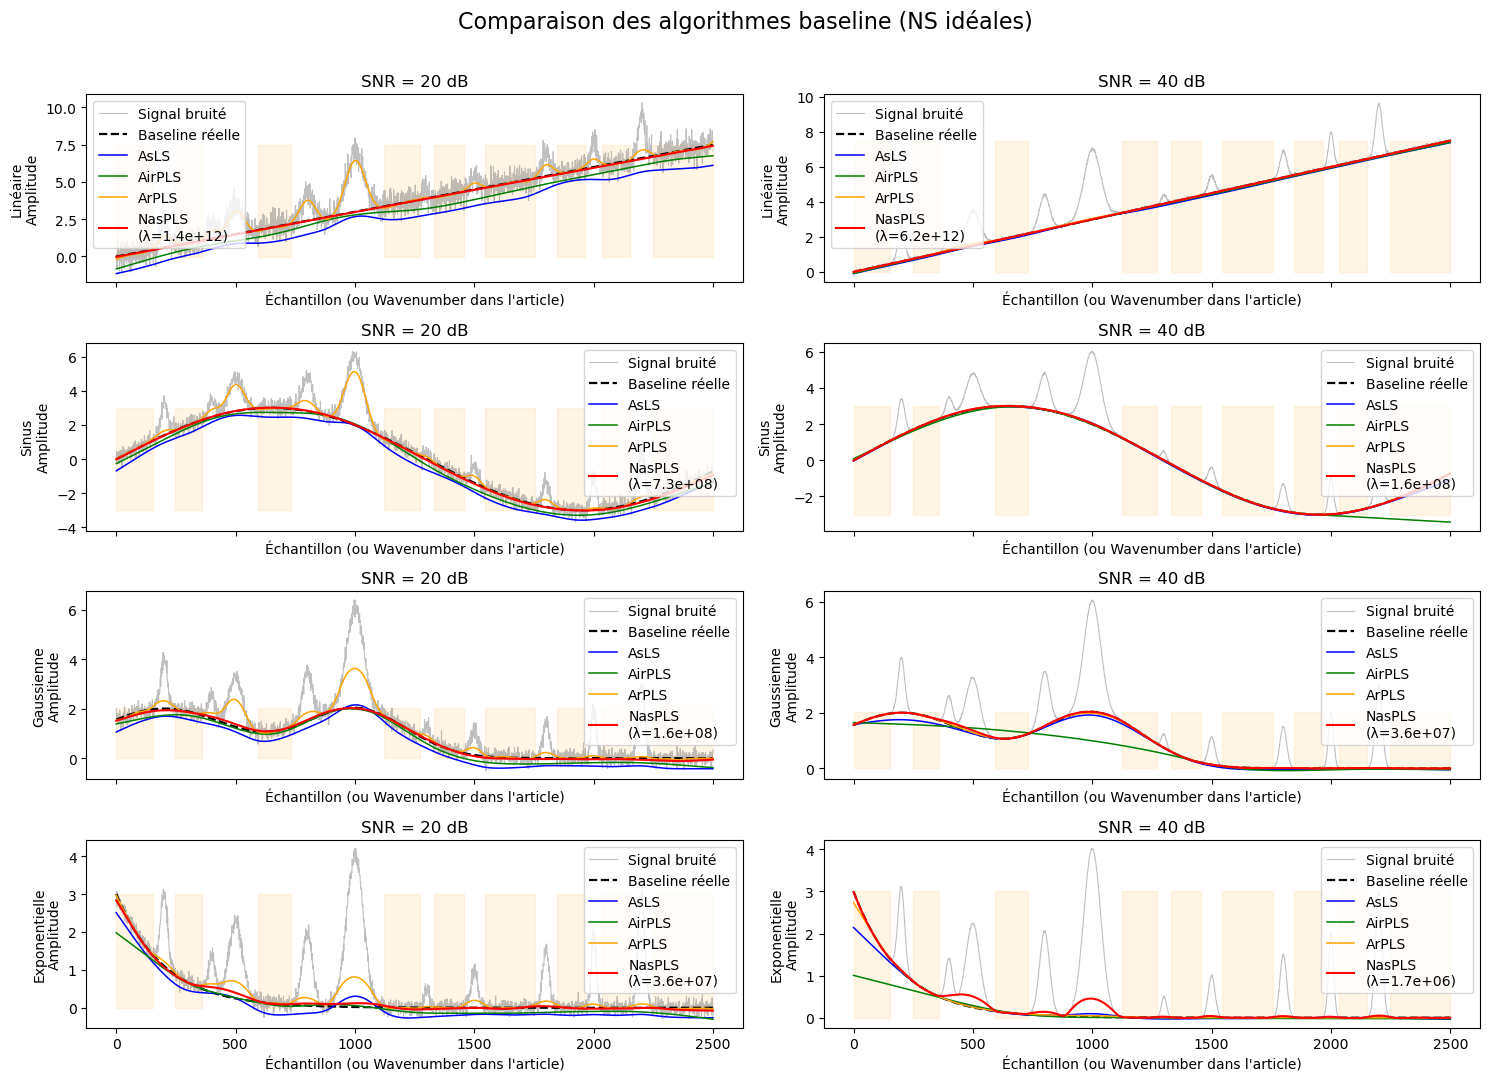

In [20]:
baselines = [
    ("Linéaire", baseline_linear),
    ("Sinus", baseline_sinusoide),
    ("Gaussienne", baseline_gaussienne),
    ("Exponentielle", baseline_exponentielle)
]
snrs = [20, 40]
lambdas = np.logspace(1, 20, 30)

results = {}
fig, axes = plt.subplots(len(baselines), len(snrs), figsize=(15, 11), sharex=True)

for i, (bname, bfunc) in enumerate(baselines):
    for j, snr in enumerate(snrs):

        res = process_baseline(bfunc, snr, lambdas)
        results[(bname, snr)] = res
        
        ax = axes[i, j]
        ax.plot(res["x"], res["y_total"], color='gray', lw=0.8, alpha=0.5, label="Signal bruité")
        ax.plot(res["x"], res["y_baseline"], '--k', lw=1.6, label="Baseline réelle")
        ax.plot(res["x"], res["z_asls"], 'b', lw=1.1, label="AsLS")
        ax.plot(res["x"], res["z_airpls"], 'g', lw=1.1, label="AirPLS")
        ax.plot(res["x"], res["z_arpls"], 'orange', lw=1.1, label="ArPLS")
        ax.plot(res["x"], res["z_naspls"], 'r', lw=1.5, label=f'NasPLS\n(λ={res["lambda_naspls"]:.1e})')
        ax.fill_between(res["x"], np.min(res["y_baseline"]), np.max(res["y_baseline"]),
                        where=res["mask_ns"], color='orange', alpha=0.1)
        ax.set_title(f"SNR = {snr} dB")
        ax.set_ylabel(f"{bname}\nAmplitude")
        ax.set_xlabel("Échantillon (ou Wavenumber dans l'article)")
        ax.legend()
plt.suptitle("Comparaison des algorithmes baseline (NS idéales)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

#####  Uniquement NasPLS

C:\Users\afaqm\AppData\Local\Temp\ipykernel_17028\3898076214.py:24: RuntimeWarning: overflow encountered in exp
  w_new = np.where(d >= 0, 1 / (1 + np.exp((d - sd) / (sd + 1e-12))), 1)
C:\Users\afaqm\AppData\Local\Temp\ipykernel_17028\4237743565.py:9: RuntimeWarning: overflow encountered in exp
  w = np.where(d >= 0, 0, np.exp(t * d / np.abs(d[d < 0]).mean()))
C:\Users\afaqm\AppData\Local\Temp\ipykernel_17028\515194146.py:11: RuntimeWarning: overflow encountered in exp
  logistic = 1 / (1 + np.exp(2 * (d - (2*sd - md)) / sd))


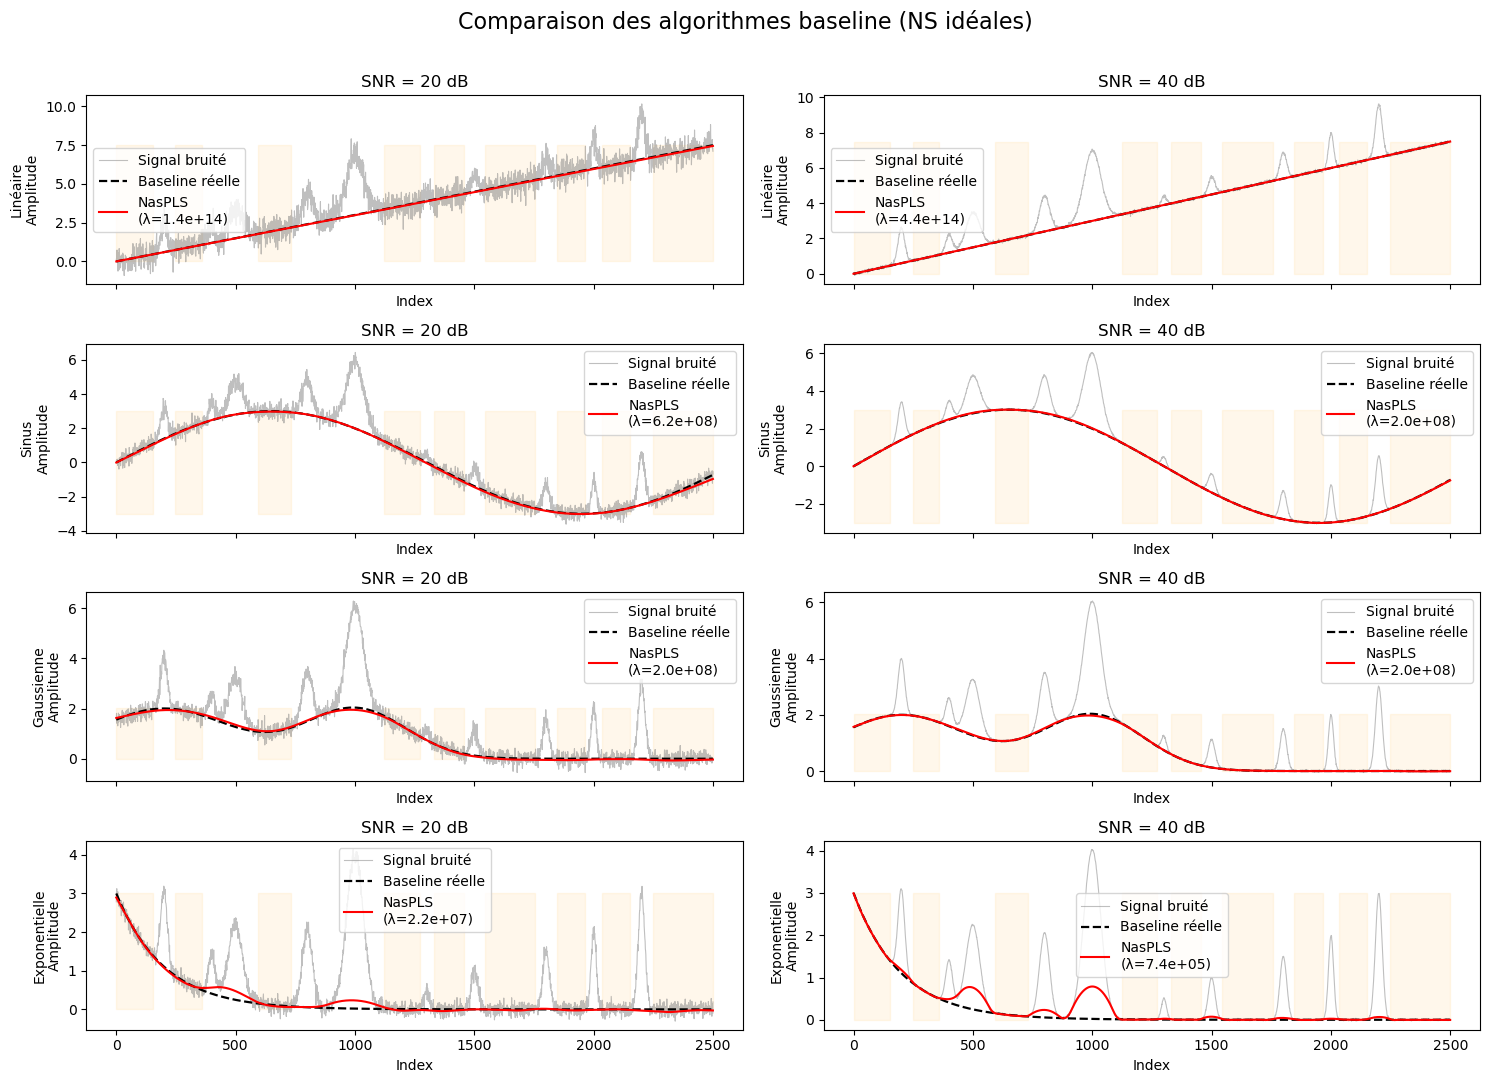

In [21]:
baselines = [
    ("Linéaire", baseline_linear),
    ("Sinus", baseline_sinusoide),
    ("Gaussienne", baseline_gaussienne),
    ("Exponentielle", baseline_exponentielle)
]
snrs = [20, 40]
lambdas = np.logspace(1, 20, 40)

results = {}

fig, axes = plt.subplots(len(baselines), len(snrs), figsize=(15, 11), sharex=True)

for i, (bname, bfunc) in enumerate(baselines):
    for j, snr in enumerate(snrs):
        res = process_baseline(bfunc, snr, lambdas)
        results[(bname, snr)] = res
        ax = axes[i, j]
        ax.plot(res["x"], res["y_total"], color='gray', lw=0.8, alpha=0.5, label="Signal bruité")
        ax.plot(res["x"], res["y_baseline"], '--k', lw=1.6, label="Baseline réelle")
        ax.plot(res["x"], res["z_naspls"], 'r', lw=1.5, label=f'NasPLS\n(λ={res["lambda_naspls"]:.1e})')
        ax.fill_between(res["x"], np.min(res["y_baseline"]), np.max(res["y_baseline"]),
                        where=res["mask_ns"], color='orange', alpha=0.08)
        ax.set_title(f"SNR = {snr} dB")
        ax.set_ylabel(f"{bname}\nAmplitude")
        ax.set_xlabel("Index")
        ax.legend()

plt.suptitle("Comparaison des algorithmes baseline (NS idéales)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

#### Tableau RMSE 

In [22]:
df = pd.DataFrame({(b, snr): res["rmse_all"] for (b, snr), res in results.items()}).T
df.index.names = ["Baseline", "SNR"]

print("\nRMSE sur toute la baseline :")
display(df.round(4))


RMSE sur toute la baseline :


AsLS  AirPLS   ArPLS  NasPLS
Baseline      SNR                                
Linéaire      20   0.9958  0.5400  0.6971  0.0275
              40   0.0806  0.0516  0.0340  0.0028
Sinus         20   0.5028  0.2685  0.6142  0.0475
              40   0.0691  0.5243  0.0138  0.0133
Gaussienne    20   0.3592  0.1980  0.3870  0.0475
              40   0.0906  0.3844  0.0138  0.0175
Exponentielle 20   0.2023  0.1922  0.1862  0.0802
              40   0.1082  0.3190  0.0232  0.1910

In [73]:
print("\nRMSE sur toute la baseline (en µ.a.) :\n")

for snr in snrs:
    print(f"SNR = {snr} dB")
    print("-" * 50)
    for bname, _ in baselines:
        scores = results[(bname, snr)]["rmse_all"]
        scores_fmt = ", ".join([f"{k}: {v:.4f}" for k, v in scores.items()])
        print(f"{bname:<15} | {scores_fmt}")
    print()



RMSE sur toute la baseline (en µ.a.) :

SNR = 20 dB
--------------------------------------------------
Linéaire        | AsLS: 0.9958, AirPLS: 0.5400, ArPLS: 0.6971, NasPLS: 0.0245
Sinus           | AsLS: 0.5028, AirPLS: 0.2685, ArPLS: 0.6142, NasPLS: 0.0583
Gaussienne      | AsLS: 0.3592, AirPLS: 0.1980, ArPLS: 0.3870, NasPLS: 0.0482
Exponentielle   | AsLS: 0.2023, AirPLS: 0.1922, ArPLS: 0.1862, NasPLS: 0.0794

SNR = 40 dB
--------------------------------------------------
Linéaire        | AsLS: 0.0806, AirPLS: 0.0516, ArPLS: 0.0340, NasPLS: 0.0035
Sinus           | AsLS: 0.0691, AirPLS: 0.5243, ArPLS: 0.0138, NasPLS: 0.0119
Gaussienne      | AsLS: 0.0906, AirPLS: 0.3844, ArPLS: 0.0138, NasPLS: 0.0168
Exponentielle   | AsLS: 0.1082, AirPLS: 0.3190, ArPLS: 0.0232, NasPLS: 0.1940



#### Conclusion

L’étude comparative menée entre les méthodes de correction de ligne de base — AsLS, AirPLS, ArPLS et NasPLS — met clairement en évidence la supériorité de l’approche NasPLS proposée dans ce travail.

L’analyse des erreurs quadratiques moyennes (RMSE) sur différents profils de baseline (linéaire, sinusoïdale, gaussienne et exponentielle) et à deux rapports signal sur bruit (SNR) révèle plusieurs points qui sont essentiels et qui ont été aussi montrés dans l'article sur lequel ce Notebook se base :

- Dans tous les scénarios testés, NasPLS obtient les RMSE les plus faibles, souvent d’un ordre de grandeur inférieur à ceux des méthodes classiques montrant sa robustesse.
Par exemple, à $20,\mathrm{dB}$ sur une baseline linéaire, NasPLS atteint une erreur de seulement $0.0245,\mu a$, contre $0.9958,\mu a$ pour AsLS et $0.5400,\mu a$ pour AirPLS.
Cette tendance se confirme à $40,\mathrm{dB}$, avec une erreur minimale de $0.0035,\mu a$ sur la baseline linéaire.

- Le NasPLS conserve d’excellentes performances quel que soit le profil de la ligne de base. Même sur des formes complexes comme la sinusoïdale ou la gaussienne, l’algorithme maintient un niveau d’erreur significativement plus bas que ses concurrents. Cela confirme l’efficacité du mécanisme de pondération adaptative et de la sélection dynamique de $\lambda$ dans l’optimisation.

- L’algorithme reste performant aussi bien à faible qu’à fort SNR. La diminution de l’erreur entre $20,\mathrm{dB}$ et $40,\mathrm{dB}$ est particulièrement marquée, soulignant la capacité de NasPLS à exploiter l’information spectrale disponible sans sur-ajuster la ligne de base.

- On note toutefois un léger relâchement des performances sur certaines baselines spécifiques (par exemple exponentielle à $40,\mathrm{dB}$), indiquant que des ajustements supplémentaires de la pondération locale ou de la stratégie de régularisation pourraient encore améliorer la méthode dans des conditions extrêmes.